In [1]:
import pandas as pd
import dask.dataframe as dd
import dask
import numpy as np
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_log_error
from glob import glob
import os
import gc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import tqdm

gc.collect()

40

In [2]:
train_path = '/home/stargix/Desktop/hackathons/datathon/train/train'
test_path = '/home/stargix/Desktop/hackathons/datathon/test/test'

In [3]:
# Definir columnas necesarias
required_columns = [
    'row_id', 'datetime',
    'buyer_d7', 'iap_revenue_d7',
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory', 
    'advertiser_bottom_taxonomy_level',
    'country', 'region',
    'dev_make', 'dev_model', 'dev_os', 'dev_osv',
    'carrier',
    'hour', 'weekday', 'weekend_ratio', 'hour_ratio',
    'release_date', 'release_msrp',
    'avg_act_days', 'avg_daily_sessions', 'avg_days_ins', 'avg_duration',
    'weeks_since_first_seen', 'wifi_ratio',
    'retentiond7',
    'city_hist', 'country_hist', 'region_hist', 'dev_language_hist', 'dev_osv_hist',
    'cpm', 'cpm_pct_rk', 'ctr', 'ctr_pct_rk',
    'iap_revenue_usd_bundle', 'iap_revenue_usd_category',
    'num_buys_bundle', 'num_buys_category',
    'last_buy', 'last_ins',
    'bcat', 'bcat_bottom_taxonomy',
    'bundles_cat', 'bundles_cat_bottom_taxonomy', 
    'bundles_ins',
    'new_bundles', 'user_bundles', 'user_bundles_l28d',
    'advertiser_actions_action_count', 'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_count', 'user_actions_bundles_action_last_timestamp',
    'last_advertiser_action',
    'first_request_ts', 'first_request_ts_bundle', 
    'first_request_ts_category_bottom_taxonomy',
    'rwd_prank',
    'whale_users_bundle_num_buys_prank', 'whale_users_bundle_revenue_prank'
]

# Cargar datos (10% de los archivos)
parquet_files_train = glob(os.path.join(train_path, '**/part-*.parquet'), recursive=True)
num_files_train = max(1, int(len(parquet_files_train) * 0.1))
parquet_files_train = parquet_files_train[:num_files_train]

try:
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow', columns=required_columns)
    print(f"✓ Train cargado con {num_files_train} archivos")
except Exception as e:
    print(f"⚠️ Cargando todas las columnas: {e}")
    train_ddf = dd.read_parquet(parquet_files_train, engine='pyarrow')

# Computar a Pandas
train_df = train_ddf.compute(scheduler='synchronous')
print(f"✓ Train shape: {train_df.shape}")

✓ Train cargado con 14 archivos
✓ Train shape: (2104266, 62)
✓ Train shape: (2104266, 62)


In [4]:
# Definir features categóricas
cat_features = [
    'advertiser_bundle', 'advertiser_category', 'advertiser_subcategory',
    'country', 'region', 'dev_make', 'dev_model', 'dev_os', 'dev_osv'
]

labels_to_exclude = [
    'buyer_d1', 'buyer_d7', 'buyer_d14', 'buyer_d28',
    'buy_d7', 'buy_d14', 'buy_d28',
    'iap_revenue_d7', 'iap_revenue_d14', 'iap_revenue_d28',
    'registration', 'retention_d1_to_d7', 'retention_d3_to_d7',
    'retention_d7_to_d14', 'retention_d1', 'retention_d3', 'retention_d7',
    'row_id', 'datetime',
    'advertiser_actions_action_last_timestamp',
    'user_actions_bundles_action_last_timestamp',
    'first_request_ts', 'first_request_ts_bundle',
    'first_request_ts_category_bottom_taxonomy'
]

cat_features = [c for c in cat_features if c in train_df.columns]

# Label Encoding para categorías
label_encoders = {}
for col in cat_features:
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col].astype(str).fillna("__NA__"))
    label_encoders[col] = le

# Features numéricas
numeric_features = [
    c for c in train_df.columns
    if c not in labels_to_exclude and c not in cat_features
    and train_df[c].dtype in ['int64', 'int32', 'int16', 'int8', 'float32', 'float64']
]

# Features finales
features = numeric_features + cat_features
print(f"Total features: {len(features)}")

Total features: 19


In [5]:
# Split temporal (80/20)
train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))
cutoff = train_df['datetime'].quantile(0.8)
val_mask = train_df['datetime'] >= cutoff

X_train = train_df[~val_mask][features]
X_val = train_df[val_mask][features]

# Target
y_train = train_df[~val_mask]['iap_revenue_d7']
y_val = train_df[val_mask]['iap_revenue_d7']

# Transform con log1p
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

print(f"Train: {len(X_train):,} samples")
print(f"Val: {len(X_val):,} samples")

/tmp/ipykernel_166034/3862451816.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  train_df['datetime'] = pd.to_datetime(train_df['datetime'].astype(str))


Train: 1,640,665 samples
Val: 463,601 samples


In [6]:
# Preprocesar datos
for col in X_train.select_dtypes(include=['object']).columns:
    if col not in cat_features:
        X_train[col] = pd.to_numeric(X_train[col], errors='coerce')
        X_val[col] = pd.to_numeric(X_val[col], errors='coerce')

X_train = X_train.fillna(0)
X_val = X_val.fillna(0)

for col in cat_features:
    if col in X_train.columns:
        X_train[col] = X_train[col].astype('category')
        X_val[col] = X_val[col].astype('category')

print("✓ Datos preprocesados")

✓ Datos preprocesados


In [7]:
# PARÁMETROS OPTIMIZADOS
params_optimized = {
    'objective': 'regression',
    'metric': 'rmse',
    'learning_rate': 0.03,
    'num_leaves': 63,
    'max_depth': -1,
    'min_data_in_leaf': 50,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'device': 'cpu'
}

print("=" * 60)
print("ENTRENANDO MODELO OPTIMIZADO")
print("=" * 60)
print("Parámetros:")
print(f"  Learning rate: {params_optimized['learning_rate']}")
print(f"  Num leaves: {params_optimized['num_leaves']}")
print(f"  Max depth: {params_optimized['max_depth']}")
print(f"  Min data in leaf: {params_optimized['min_data_in_leaf']}")
print("=" * 60)

ENTRENANDO MODELO OPTIMIZADO
Parámetros:
  Learning rate: 0.03
  Num leaves: 63
  Max depth: -1
  Min data in leaf: 50


In [8]:
# Entrenar modelo
cat_features_valid = [col for col in cat_features if col in features]

train_ds = lgb.Dataset(X_train, label=y_train_log, categorical_feature=cat_features_valid)
val_ds = lgb.Dataset(X_val, label=y_val_log, reference=train_ds)

model = lgb.train(
    params_optimized,
    train_ds,
    num_boost_round=2000,
    valid_sets=[train_ds, val_ds],
    callbacks=[lgb.early_stopping(stopping_rounds=100)]
)

print(f"\n✓ Modelo entrenado ({model.best_iteration} iteraciones)")

Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[279]	training's rmse: 0.378265	valid_1's rmse: 0.39028

✓ Modelo entrenado (279 iteraciones)
Early stopping, best iteration is:
[279]	training's rmse: 0.378265	valid_1's rmse: 0.39028

✓ Modelo entrenado (279 iteraciones)


In [9]:
# Evaluar en validación
pred_log = model.predict(X_val)
pred = np.expm1(pred_log).clip(0, None)

msle = mean_squared_log_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)

print("=" * 60)
print("RESULTADOS EN VALIDACIÓN")
print("=" * 60)
print(f"MSLE: {msle:.6f}")
print(f"RMSE: ${rmse:.2f}")
print(f"Revenue promedio predicho: ${pred.mean():.2f}")
print(f"Revenue promedio real: ${y_val.mean():.2f}")
print("=" * 60)

RESULTADOS EN VALIDACIÓN
MSLE: 0.152305
RMSE: $112463.12
Revenue promedio predicho: $0.10
Revenue promedio real: $1.43


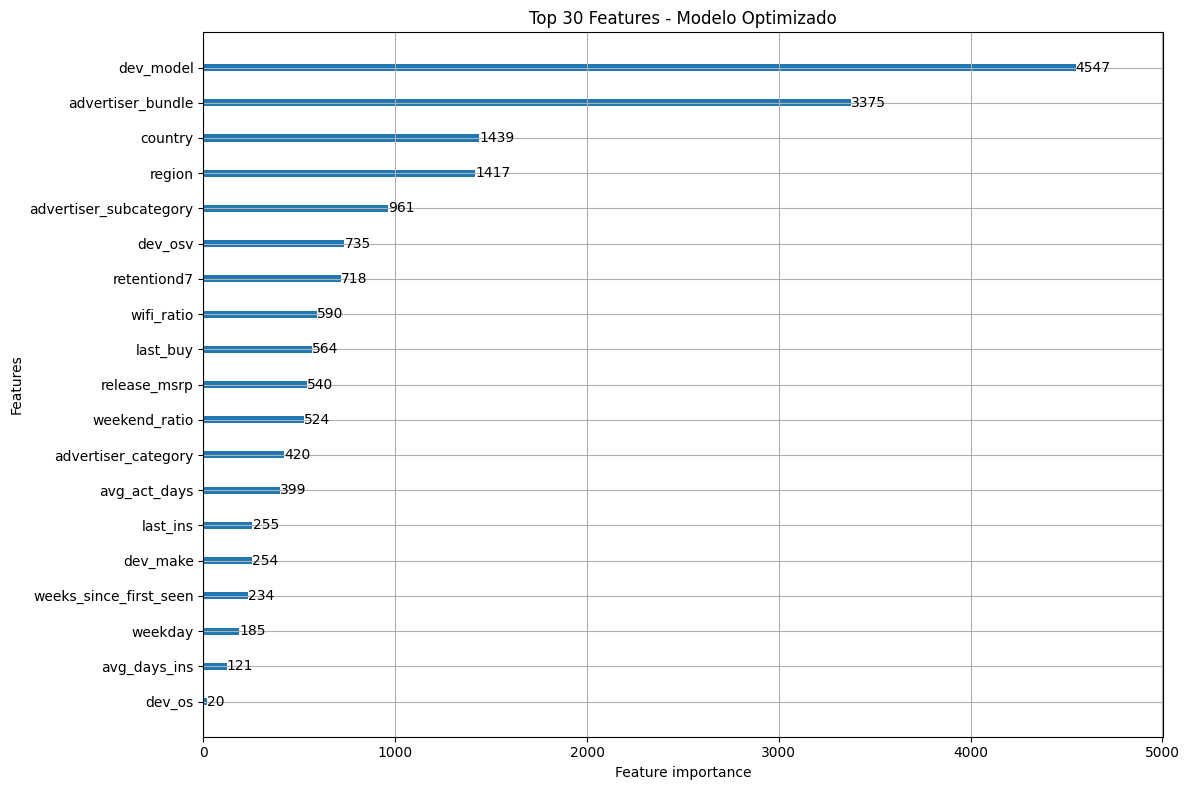

: 

In [ ]:
# Feature importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 8))
lgb.plot_importance(model, max_num_features=30, ax=ax, title='Top 30 Features - Modelo Optimizado')
plt.tight_layout()
plt.show()

In [ ]:
# PREDICCIÓN EN TEST SET COMPLETO
from tqdm import tqdm

print("=" * 60)
print("GENERANDO PREDICCIONES PARA TEST SET")
print("=" * 60)

# Cargar test
parquet_files_test = glob(os.path.join(test_path, '**/part-*.parquet'), recursive=True)
print(f"Total archivos test: {len(parquet_files_test)}")

test_ddf = dd.read_parquet(parquet_files_test, engine='pyarrow')
print(f"✓ Test cargado")

# Función de preprocesamiento
def preprocess_partition(partition):
    # Label encoding
    for col in cat_features:
        if col in partition.columns and col in label_encoders:
            partition[col] = partition[col].astype(str).fillna("__NA__")
            le = label_encoders[col]
            partition[col] = partition[col].map(
                lambda x: le.transform([x])[0] if x in le.classes_ else -1
            )
    
    # Asegurar features
    for f in features:
        if f not in partition.columns:
            partition[f] = 0
    
    X = partition[features].copy()
    
    # Convertir tipos
    for col in X.columns:
        if col not in cat_features and X[col].dtype == 'object':
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    X = X.fillna(0)
    
    for col in cat_features:
        if col in X.columns:
            X[col] = X[col].astype('category')
    
    return X, partition['row_id']

# Procesar por particiones
test_ddf = test_ddf.persist()
n_partitions = test_ddf.npartitions
print(f"\nProcesando {n_partitions} particiones...")

predictions_list = []
row_ids_list = []

# Usar tqdm para mostrar progreso
for i in tqdm(range(n_partitions), desc="Prediciendo particiones", unit="partición"):
    try:
        print(f"\nProcesando partición {i+1}/{n_partitions}...")
        partition = test_ddf.get_partition(i).compute()
        X_partition, row_ids_partition = preprocess_partition(partition)
        
        pred_log = model.predict(X_partition)
        pred = np.expm1(pred_log).clip(0, None)
        
        predictions_list.append(pred)
        row_ids_list.append(row_ids_partition.values)
        
        # Limpiar memoria más agresivamente
        del partition, X_partition, pred_log
        gc.collect()
        
    except Exception as e:
        print(f"\n⚠️ Error en partición {i+1}: {e}")
        continue

# Combinar predicciones
print("\nCombinando predicciones...")
all_predictions = np.concatenate(predictions_list)
all_row_ids = np.concatenate(row_ids_list)

print(f"✓ Total predicciones: {len(all_predictions):,}")

GENERANDO PREDICCIONES PARA TEST SET
Total archivos test: 96
✓ Test cargado


In [ ]:
# Crear submission
submission = pd.DataFrame({
    'row_id': all_row_ids,
    'iap_revenue_d7': all_predictions
})

print("=" * 60)
print("SUBMISSION FINAL")
print("=" * 60)
print(f"Total filas: {len(submission):,}")
print(f"Row IDs únicos: {submission['row_id'].nunique():,}")
print(f"Duplicados: {submission['row_id'].duplicated().sum()}")
print(f"NaN: {submission['iap_revenue_d7'].isna().sum()}")
print(f"\nEstadísticas:")
print(submission['iap_revenue_d7'].describe())

# Guardar
submission_path = '/home/stargix/Desktop/hackathons/datathon/submission_optimized.csv'
submission.to_csv(submission_path, index=False)
print(f"\n✓ Guardado en: {submission_path}")
print("=" * 60)